In [22]:
import numpy as np
import seaborn as sns
import transformation
import significantdigits as sd
from matplotlib import pyplot as plt
from fsl.transform import flirt, affine


In [2]:
path_PD = './outputs_PD/anat-12dofs'
path_HC = './outputs_HC/anat-12dofs'

In [3]:
paths_PD = transformation.get_matrices_paths(path_PD)
paths_HC = transformation.get_matrices_paths(path_HC)

In [4]:
mat_dic_PD = transformation.get_matrices(paths_PD)
mat_dic_HC = transformation.get_matrices(paths_HC)

In [5]:
mean_PD, std_PD = np.zeros((50,4,4)), np.zeros((50,4,4))
mean_HC, std_HC = np.zeros((50,4,4)), np.zeros((50,4,4))

for i,sub in enumerate(mat_dic_PD.keys()):
    mean_PD[i] = np.mean(mat_dic_PD[sub]["mca"], axis=0)
    std_PD[i] = np.std(mat_dic_PD[sub]["mca"], axis=0)

for i,sub in enumerate(mat_dic_HC.keys()):
    mean_HC[i] = np.mean(mat_dic_HC[sub]['mca'], axis=0)
    std_HC[i] = np.std(mat_dic_HC[sub]["mca"], axis=0)


In [20]:
mean_PD[0]

array([[ 1.03657019e+00, -2.16879669e-02,  7.09773111e-02,
        -3.81499894e+00],
       [-1.03338692e-03,  1.07185337e+00,  7.47641274e-02,
        -2.54993864e+00],
       [-6.79830301e-02, -5.52040298e-02,  1.07668213e+00,
        -5.95488795e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [21]:
std_PD[0]

array([[2.34194164e-05, 4.72226021e-04, 1.13435455e-04, 4.40786790e-02],
       [5.26613991e-04, 8.26092187e-05, 1.52723722e-04, 4.87566681e-02],
       [1.49846303e-04, 2.02517635e-04, 1.08858907e-04, 2.70641620e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [6]:
def cell_significant_digit(mat_dic):

    significant_digits_dict = {key:np.zeros((4,4)) for key in mat_dic.keys()}
    for key in mat_dic.keys():
        mean_sub = np.mean(mat_dic[key]['mca'], axis=0)
        for i in range(4):
            for j in range(4):
                significant_digits_dict[key][i,j] = sd.significant_digits(mat_dic[key]['mca'][:,i,j], reference=mean_sub[i,j], basis=10)
    
    return significant_digits_dict

In [7]:
cell_significant_digits_dict_PD = cell_significant_digit(mat_dic_PD)
cell_significant_digits_dict_HC = cell_significant_digit(mat_dic_HC)

/lustre06/project/6061841/niusham/mca_linear_registration/.venv/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)


In [8]:
cell_significant_digits_PD = np.array(list(cell_significant_digits_dict_PD.values()))
cell_significant_digits_HC = np.array(list(cell_significant_digits_dict_HC.values()))

In [9]:
np.max(cell_significant_digits_PD, axis=0)

array([[ 4.37104303,  2.74516568,  4.06436344,  2.78036936],
       [ 3.72823316,  4.37954739,  3.10545443,  3.19706534],
       [ 2.76841606,  3.46591067,  3.72546666,  2.89121485],
       [15.09990363, 15.09990363, 15.09990363, 15.09990363]])

In [10]:
np.max(cell_significant_digits_HC, axis=0)

array([[ 4.45679749,  2.63711068,  2.64076903,  2.78584956],
       [ 2.9440517 ,  4.51318849,  3.00676552,  3.09448483],
       [ 2.7079212 ,  3.19049237,  4.04447148,  3.11014282],
       [15.09990363, 15.09990363, 15.09990363, 15.09990363]])

In [11]:
np.mean(cell_significant_digits_PD, axis=0)

array([[ 3.4644545 ,  1.37350673,  1.49718741,  1.6203995 ],
       [ 1.28983991,  3.42226385,  2.08675437,  2.05864231],
       [ 1.20075036,  2.32388483,  2.87418416,  2.07811176],
       [15.09990363, 15.09990363, 15.09990363, 15.09990363]])

In [12]:
np.mean(cell_significant_digits_HC, axis=0)

array([[ 3.78539466,  1.26976946,  1.21905954,  1.48139317],
       [ 1.33051513,  3.61392229,  2.14935121,  2.18077753],
       [ 1.15344231,  2.22925417,  3.21376706,  2.25939095],
       [15.09990363, 15.09990363, 15.09990363, 15.09990363]])

In [13]:
np.min(cell_significant_digits_PD, axis=0)

array([[-0.42819398, -0.58785109, -1.25113768, -0.85836331],
       [-1.13662462, -0.43864345, -0.15676659, -2.52290452],
       [-0.5692634 , -0.06183924, -0.14642001, -0.31383016],
       [15.09990363, 15.09990363, 15.09990363, 15.09990363]])

In [14]:
np.min(cell_significant_digits_HC, axis=0)

array([[ 2.55292504, -1.28592239, -0.89943436, -0.25056002],
       [-0.38430498,  2.74445647,  0.2335309 ,  0.38246343],
       [-0.50976588,  0.10328191,  2.4985375 ,  0.98636508],
       [15.09990363, 15.09990363, 15.09990363, 15.09990363]])

/lustre06/project/6061841/niusham/mca_linear_registration/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 70.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'MCA means for each cell _PD subjects_')

/lustre06/project/6061841/niusham/mca_linear_registration/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 70.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


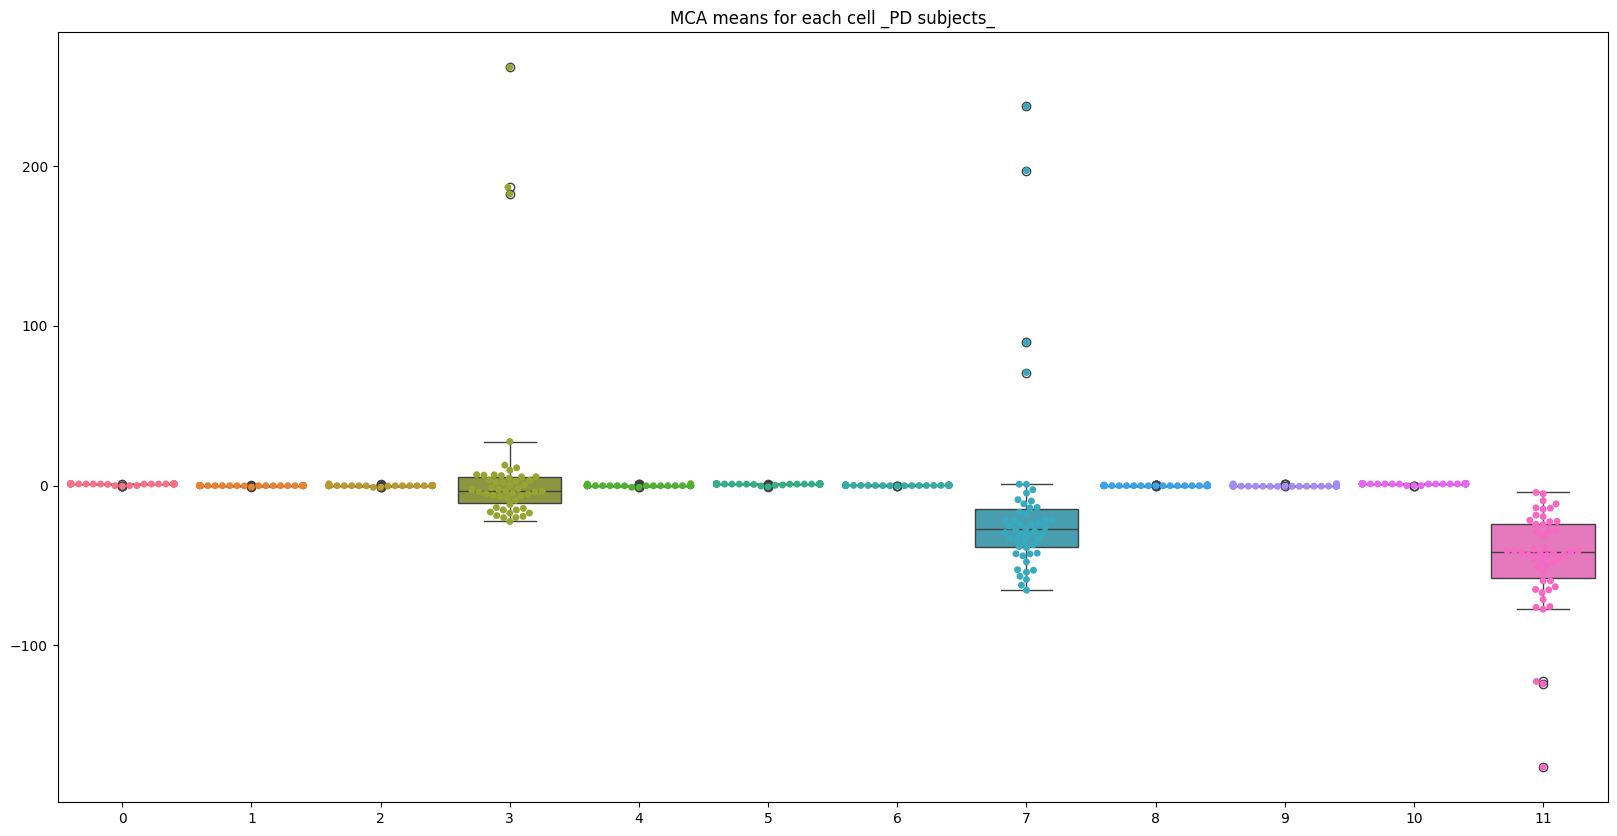

In [61]:
plt.figure(figsize=(20,10))
_ = sns.swarmplot(mean_PD[:,:3,:].reshape(50,12))
_ = sns.boxplot(mean_PD[:,:3,:].reshape(50,12))
plt.title('MCA means for each cell _PD subjects_')

/lustre06/project/6061841/niusham/mca_linear_registration/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 70.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/lustre06/project/6061841/niusham/mca_linear_registration/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 68.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/lustre06/project/6061841/niusham/mca_linear_registration/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 66.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/lustre06/project/6061841/niusham/mca_linear_registration/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 64.0% of the points cannot be placed; you m

Text(0.5, 1.0, 'MCA SD for each cell _PD subjects_')

/lustre06/project/6061841/niusham/mca_linear_registration/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 70.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/lustre06/project/6061841/niusham/mca_linear_registration/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 68.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/lustre06/project/6061841/niusham/mca_linear_registration/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 66.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/lustre06/project/6061841/niusham/mca_linear_registration/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 64.0% of the points cannot be placed; you m

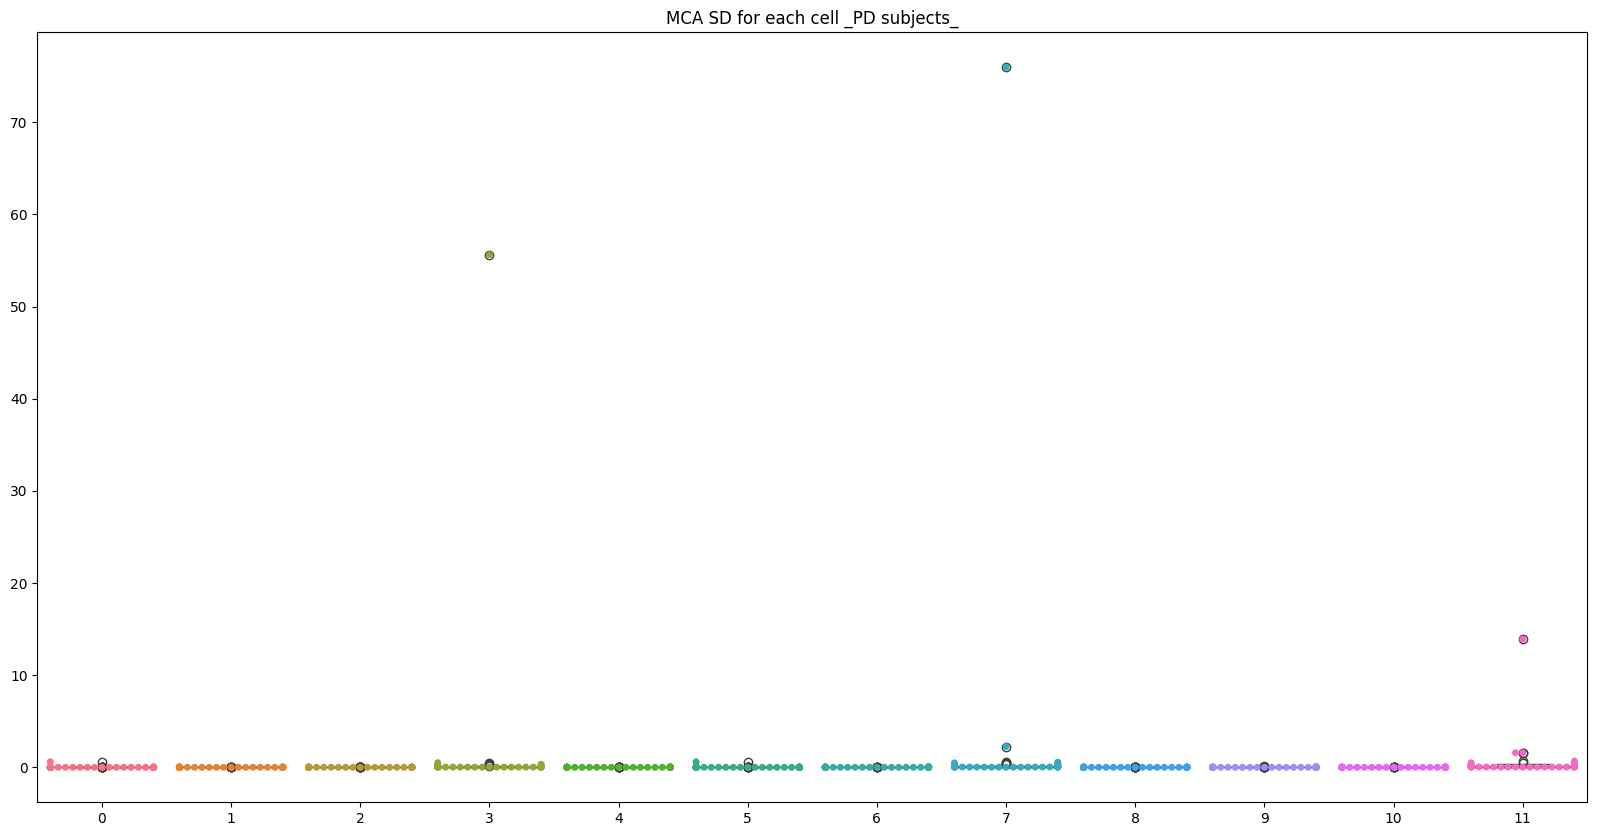

In [63]:
plt.figure(figsize=(20,10))
_ = sns.swarmplot(std_PD[:,:3,:].reshape(50,12))
_ = sns.boxplot(std_PD[:,:3,:].reshape(50,12))
plt.title('MCA SD for each cell _PD subjects_')

/lustre06/project/6061841/niusham/mca_linear_registration/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 70.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'MCA means for each cell _HC subjects_')

/lustre06/project/6061841/niusham/mca_linear_registration/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 70.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


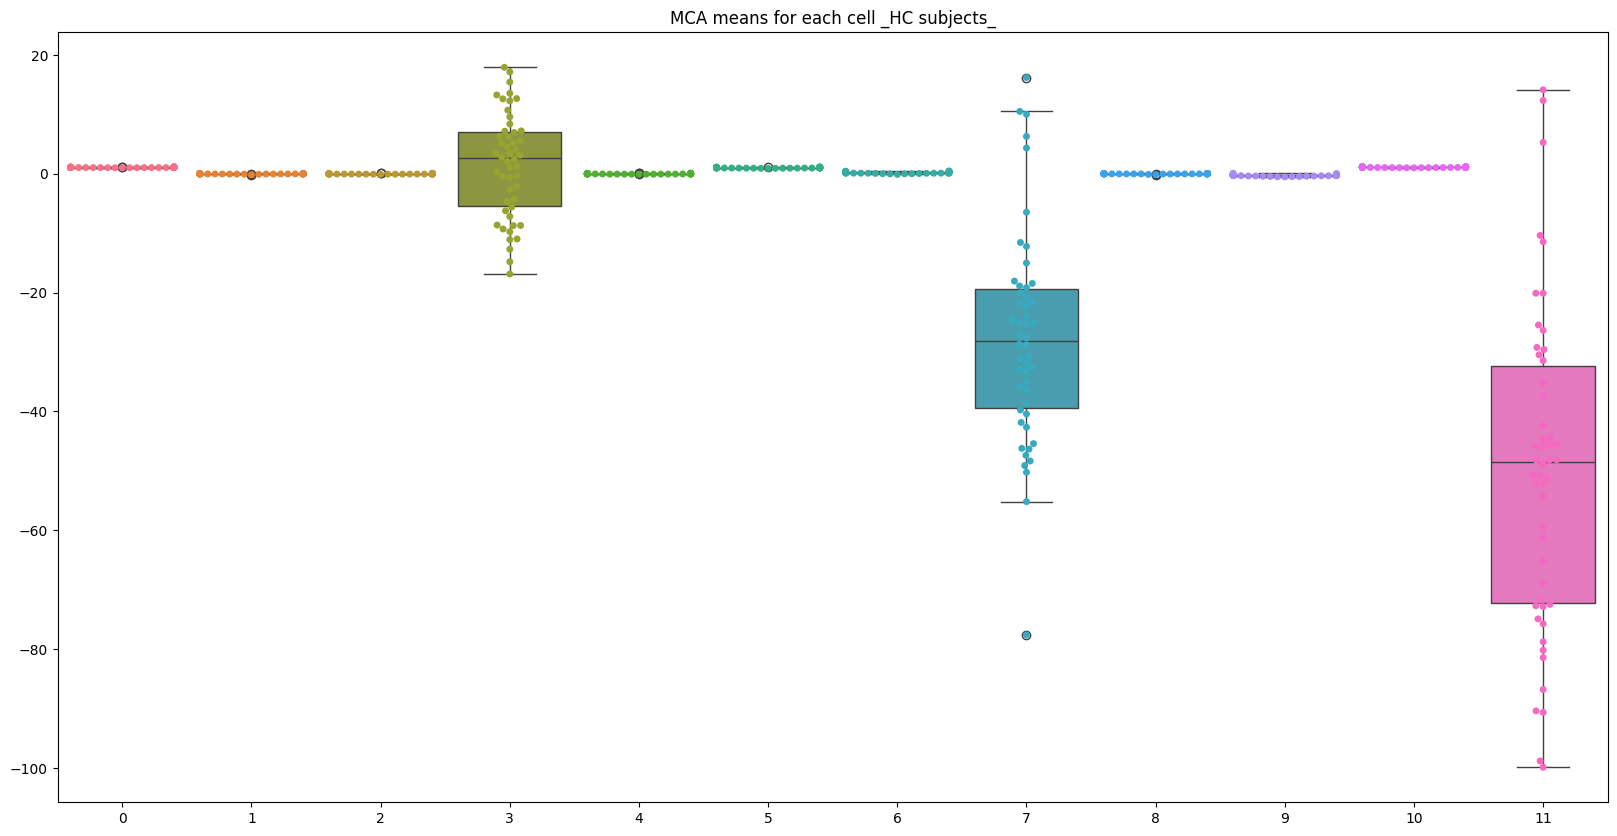

In [64]:
plt.figure(figsize=(20,10))
sns.swarmplot(mean_HC[:,:3,:].reshape(50,12))
sns.boxplot(mean_HC[:,:3,:].reshape(50,12))
plt.title('MCA means for each cell _HC subjects_')

/lustre06/project/6061841/niusham/mca_linear_registration/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 70.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/lustre06/project/6061841/niusham/mca_linear_registration/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 14.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/lustre06/project/6061841/niusham/mca_linear_registration/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 68.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/lustre06/project/6061841/niusham/mca_linear_registration/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 8.0% of the points cannot be placed; you ma

Text(0.5, 1.0, 'MCA sds for each cell _HC subjects_')

/lustre06/project/6061841/niusham/mca_linear_registration/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 70.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/lustre06/project/6061841/niusham/mca_linear_registration/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 14.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/lustre06/project/6061841/niusham/mca_linear_registration/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 68.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/lustre06/project/6061841/niusham/mca_linear_registration/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 8.0% of the points cannot be placed; you ma

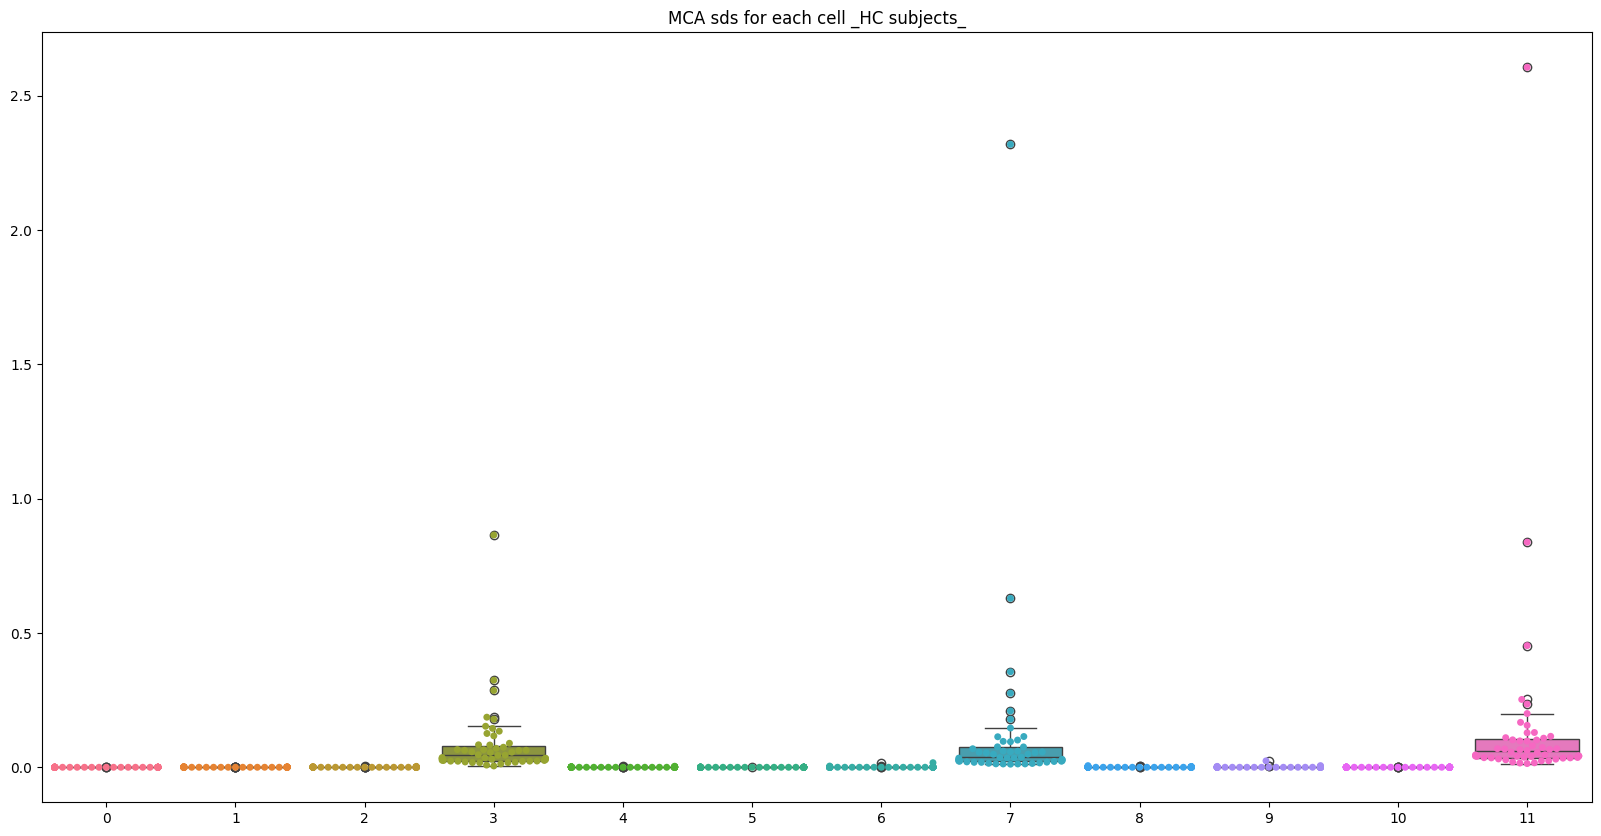

In [65]:
plt.figure(figsize=(20,10))
sns.swarmplot(std_HC[:,:3,:].reshape(50,12))
sns.boxplot(std_HC[:,:3,:].reshape(50,12))
plt.title('MCA sds for each cell _HC subjects_')

Text(0.5, 1.0, 'Significant digits for each cell _PD subjects_')

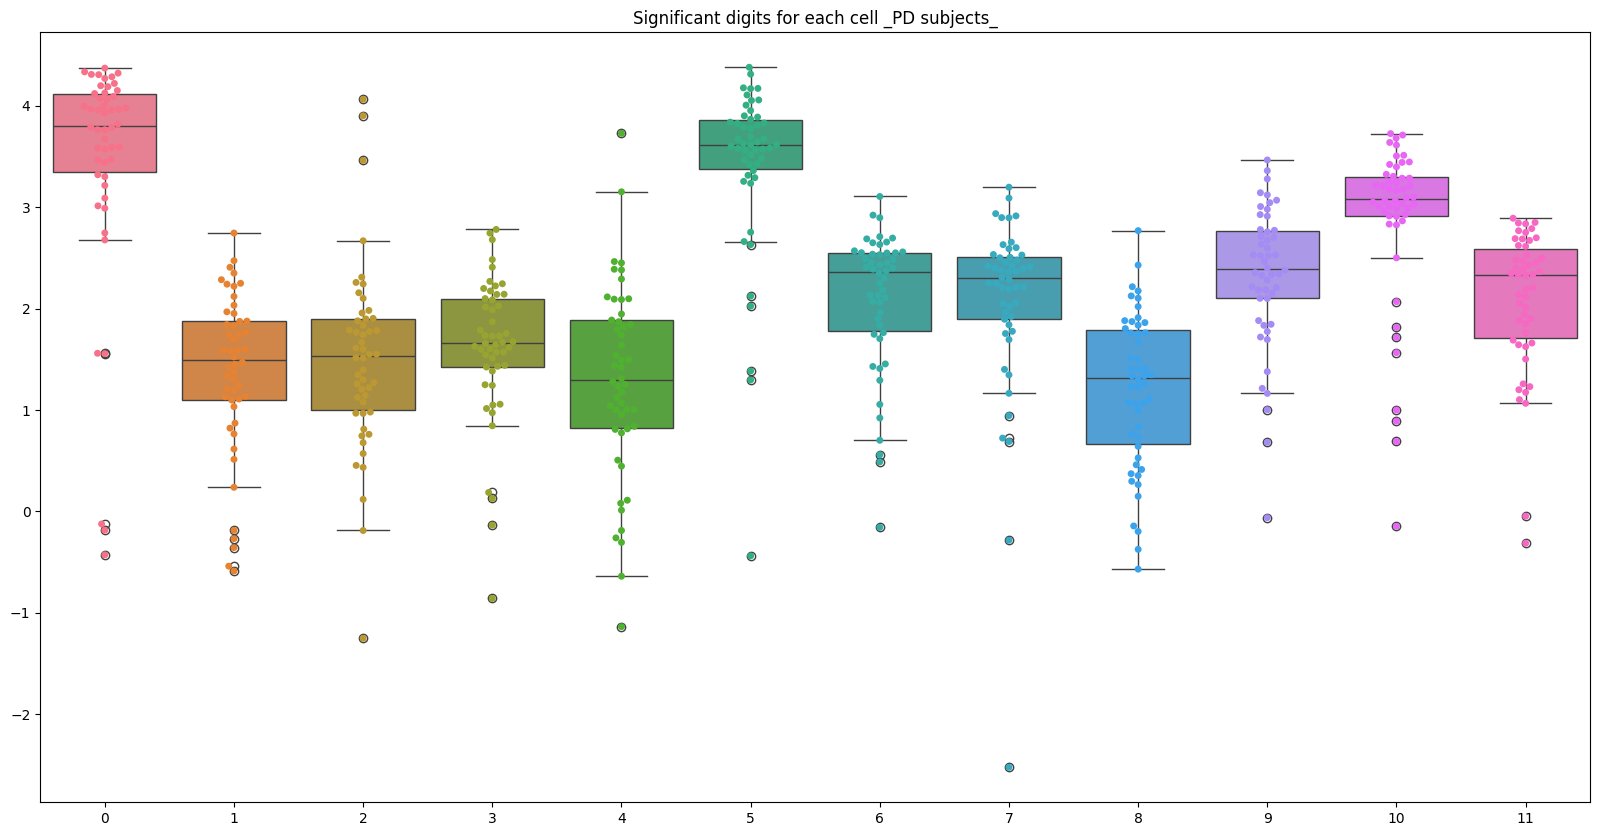

In [66]:
plt.figure(figsize=(20,10))
sns.swarmplot(cell_significant_digits_PD[:,:3,:].reshape(50,12))
sns.boxplot(cell_significant_digits_PD[:,:3,:].reshape(50,12))
plt.title('Significant digits for each cell _PD subjects_')

Text(0.5, 1.0, 'Significant digits for each cell _HC subjects_')

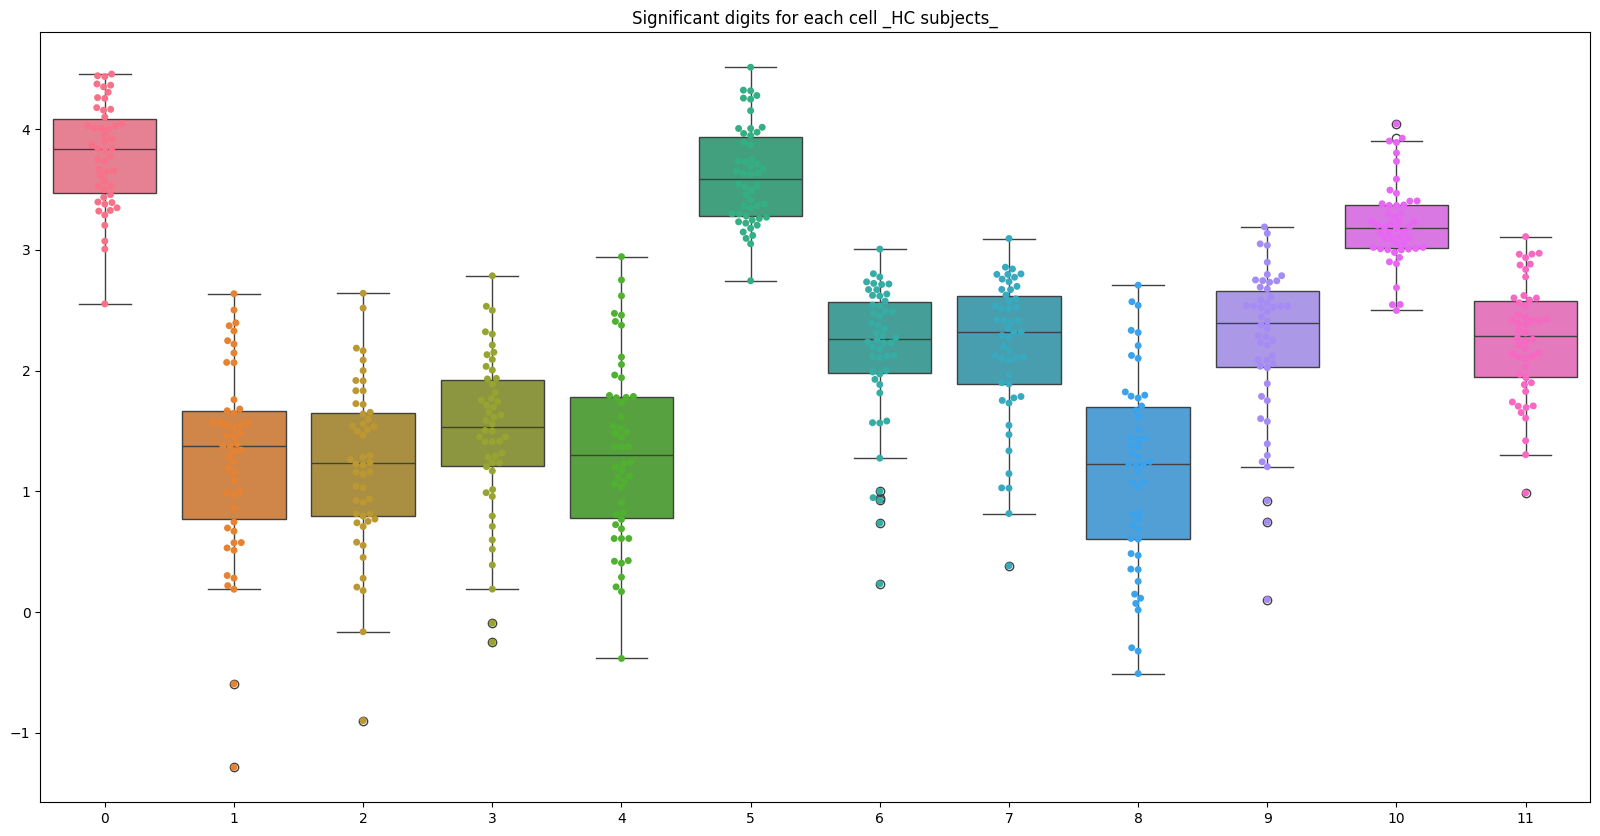

In [67]:
plt.figure(figsize=(20,10))
sns.swarmplot(cell_significant_digits_HC[:,:3,:].reshape(50,12))
sns.boxplot(cell_significant_digits_HC[:,:3,:].reshape(50,12))
plt.title('Significant digits for each cell _HC subjects_')